# Se importan las bibliotecas necesarias

In [1]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from catboost import CatBoostClassifier
%matplotlib inline

# Se lee el .csv

In [2]:
train = pd.read_csv('csv/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test = pd.read_csv('csv/test.csv')

In [5]:
word2vec_score = pd.read_csv('csv/solo_embedding_word2vec_train.csv', usecols=['word2vec_score'])
word2vec_score.head()

,word2vec_score
0,1
1,1
2,1
3,1
4,1


In [6]:
word2vec_score_test = pd.read_csv('csv/solo_embedding_word2vec_test.csv', usecols=['word2vec_score'])
word2vec_score_test.head()

,word2vec_score
0,1
1,0
2,1
3,1
4,1


In [7]:
elmo_score = pd.read_csv('csv/solo_embedding_elmo_train.csv', usecols=['elmo_score'])
elmo_score.head()

,elmo_score
0,0
1,1
2,1
3,1
4,1


In [8]:
elmo_score_test = pd.read_csv('csv/solo_embedding_elmo_test.csv', usecols=['elmo_score'])
elmo_score_test.head()

,elmo_score
0,0
1,0
2,1
3,1
4,1


In [9]:
train['word2vec_score'] = word2vec_score['word2vec_score']
train['elmo_score'] = elmo_score['elmo_score']
train.head()

,id,keyword,location,text,target,word2vec_score,elmo_score
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,1,0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,1,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,1,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,1,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,1,1


In [10]:
test['word2vec_score'] = word2vec_score_test['word2vec_score']
test['elmo_score'] = elmo_score_test['elmo_score']
test.tail()

,id,keyword,location,text,word2vec_score,elmo_score
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,1,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,1,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,1,1
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,1,0


# Elaboración del modelo

Para este modelo se utilizarán árboles de decisión para realizar las predicciones en base a los resultados arrojados por los modelos 2 y 4, los cuales se basaban en el análisis de embeddings realizados con word2vec y ELMo, respectivamente.

### Preparación del set de datos

In [11]:
train.drop(columns=['keyword','location','text'], inplace=True)

In [12]:
train.set_index('id', inplace=True)
train.head()

,target,word2vec_score,elmo_score
id,,,
1,1,1,0
4,1,1,1
5,1,1,1
6,1,1,1
7,1,1,1


In [13]:
test.drop(columns=['keyword','location','text'], inplace=True)

In [14]:
test.set_index('id', inplace=True)
test.head()

,word2vec_score,elmo_score
id,,
0,1,0
2,0,0
3,1,1
9,1,1
11,1,1


### Entrenamiento del set de datos

In [15]:
X, y = train.iloc[:,[1,2]], train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=478)
X.head()

,word2vec_score,elmo_score
id,,
1,1,0
4,1,1
5,1,1
6,1,1
7,1,1


#### XGBoost

In [16]:
xg_class = xgb.XGBClassifier(objective ='binary:logistic', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 5)

In [17]:
xg_class.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=10,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [18]:
preds = xg_class.predict(X_test)

Accuracy Score : 0.9290718038528897
Precision Score : 0.9698375870069605
Recall Score : 0.8600823045267489
F1 Score : 0.9116684841875682


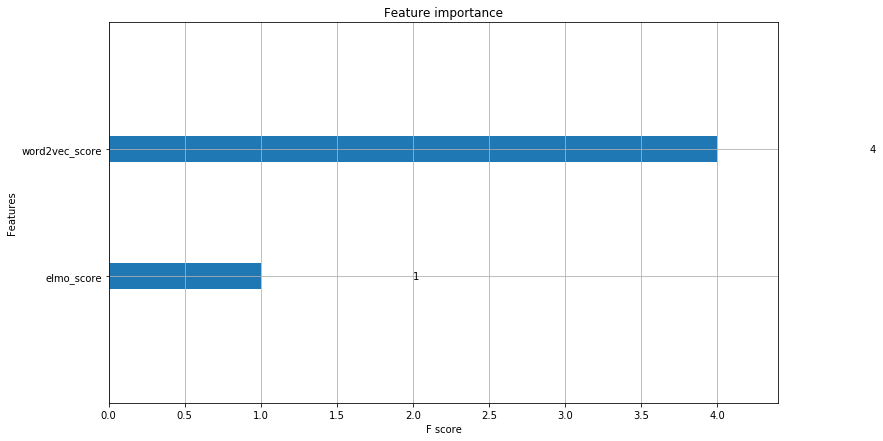

In [19]:
print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_class)

In [20]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/xgboost.csv')
# df.head()

In [21]:
# params = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.2, 0.3, 0.4],
#         'max_depth': [10, 15, 20]
#         }
# grid_acc = GridSearchCV(xg_reg, param_grid = params)
# grid_acc.fit(X_train, y_train)
# y_pred_acc = grid_acc.predict(X_test)

# # New Model Evaluation metrics 
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc.round())))
# print('Precision Score : ' + str(precision_score(y_test,y_pred_acc.round())))
# print('Recall Score : ' + str(recall_score(y_test,y_pred_acc.round())))
# print('F1 Score : ' + str(f1_score(y_test,y_pred_acc.round())))

#### RandomForest

In [22]:
rf_model = RandomForestClassifier(random_state=13, n_estimators=5, max_depth=10)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.9448336252189142
Precision Score : 0.9548387096774194
Recall Score : 0.9135802469135802
F1 Score : 0.9337539432176656


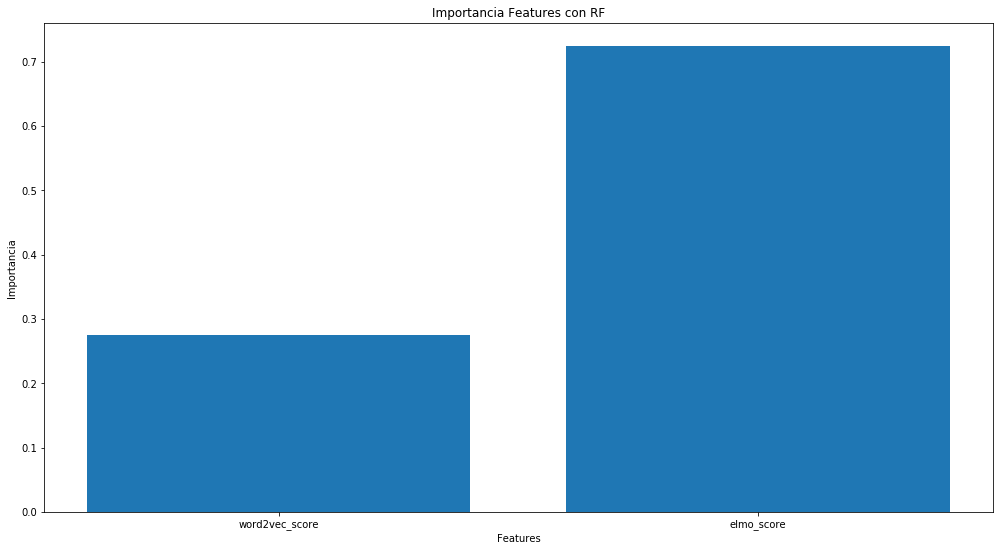

In [23]:
rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [24]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/randomForest.csv')
# df.head()

rf_model.feature_importances_
plt.figure(figsize=(17,9))
plt.bar(X_train.columns, rf_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

#### LightGBM

In [25]:
lgb_class = lgb.LGBMClassifier(learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 5)
lgb_class.fit(X_train, y_train)
preds = lgb_class.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.9448336252189142
Precision Score : 0.9548387096774194
Recall Score : 0.9135802469135802
F1 Score : 0.9337539432176656


In [26]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/lightgbm.csv')
# df.head()

#### CatBoost

In [27]:
catb = CatBoostClassifier(iterations=5)
catb.fit(X_train, y_train)
preds = catb.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Learning rate set to 0.5
0:	learn: 0.3932328	total: 56.4ms	remaining: 226ms
1:	learn: 0.2868214	total: 59.2ms	remaining: 88.8ms
2:	learn: 0.2447028	total: 61.5ms	remaining: 41ms
3:	learn: 0.2189767	total: 64.1ms	remaining: 16ms
4:	learn: 0.2072950	total: 66.2ms	remaining: 0us
Accuracy Score : 0.9448336252189142
Precision Score : 0.9548387096774194
Recall Score : 0.9135802469135802
F1 Score : 0.9337539432176656


In [28]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/catboost.csv')
# df.head()

#### GradientBoosting

In [29]:
gb = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, 
                                max_features=2, max_depth = 2, random_state = 0)
gb.fit(X_train, y_train)
preds = gb.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds.round())))
print('Precision Score : ' + str(precision_score(y_test,preds.round())))
print('Recall Score : ' + str(recall_score(y_test,preds.round())))
print('F1 Score : ' + str(f1_score(y_test,preds.round())))

Accuracy Score : 0.9448336252189142
Precision Score : 0.9548387096774194
Recall Score : 0.9135802469135802
F1 Score : 0.9337539432176656


In [30]:
# df = pd.DataFrame(preds)
# final = df.to_csv('csv/logicRegression.csv')
# df.head()

#### Majority voting

In [31]:
eclf2 = VotingClassifier(estimators=[
         ('xgb', xg_class), ('rf', rf_model), ('catb', catb), ('gb', gb), ('lgbm',lgb_class)])

In [32]:
eclf2 = eclf2.fit(X, y)

Learning rate set to 0.5
0:	learn: 0.3926451	total: 4.3ms	remaining: 17.2ms
1:	learn: 0.2860978	total: 7.94ms	remaining: 11.9ms
2:	learn: 0.2437815	total: 12.4ms	remaining: 8.29ms
3:	learn: 0.2181084	total: 18.1ms	remaining: 4.53ms
4:	learn: 0.2064270	total: 23.8ms	remaining: 0us


In [33]:
preds = eclf2.predict(X_test)

print('Accuracy Score : ' + str(accuracy_score(y_test,preds)))
print('Precision Score : ' + str(precision_score(y_test,preds)))
print('Recall Score : ' + str(recall_score(y_test,preds)))
print('F1 Score : ' + str(f1_score(y_test,preds)))

Accuracy Score : 0.9448336252189142
Precision Score : 0.9548387096774194
Recall Score : 0.9135802469135802
F1 Score : 0.9337539432176656


### Predicciones

In [34]:
test['target'] = eclf2.predict(test.iloc[:,:])

In [35]:
test.drop(columns=['word2vec_score','elmo_score'], inplace=True)
test.head()

,target
id,
0,1
2,0
3,1
9,1
11,1


In [36]:
final = test.to_csv('csv/submission_modelo5_voting.csv')